<a href="https://colab.research.google.com/github/dolmani38/OCR/blob/main/tesseract-ocr-test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install easyocr
!pip install opencv-python
!pip install pytesseract

     |████████████████████████████████| 62.4MB 50kB/s 
  Created wheel for pytesseract: filename=pytesseract-0.3.7-py2.py3-none-any.whl size=13945 sha256=58e22d74d71e016594e4a426312475d0cc752352147ac1768eed9266fdfd5ae0
  Stored in directory: /root/.cache/pip/wheels/81/20/7e/1dd0daad1575d5260916bb1e9781246430647adaef4b3ca3b3
Successfully built pytesseract


In [2]:
!!sudo apt install tesseract-ocr

['',
 'Reading package lists... 0%',
 '',
 'Reading package lists... 0%',
 '',
 'Reading package lists... 0%',
 '',
 'Reading package lists... 5%',
 '',
 'Reading package lists... 5%',
 '',
 'Reading package lists... 6%',
 '',
 'Reading package lists... 6%',
 '',
 'Reading package lists... 54%',
 '',
 'Reading package lists... 54%',
 '',
 'Reading package lists... 55%',
 '',
 'Reading package lists... 55%',
 '',
 'Reading package lists... 65%',
 '',
 'Reading package lists... 65%',
 '',
 'Reading package lists... 66%',
 '',
 'Reading package lists... 66%',
 '',
 'Reading package lists... 69%',
 '',
 'Reading package lists... 76%',
 '',
 'Reading package lists... 76%',
 '',
 'Reading package lists... 76%',
 '',
 'Reading package lists... 76%',
 '',
 'Reading package lists... 76%',
 '',
 'Reading package lists... 76%',
 '',
 'Reading package lists... 76%',
 '',
 'Reading package lists... 76%',
 '',
 'Reading package lists... 84%',
 '',
 'Reading package lists... 84%',
 '',
 'Reading pack

In [3]:
!which tesseract

/usr/bin/tesseract


In [5]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'


In [6]:
!git clone https://github.com/dolmani38/OCR

Cloning into 'OCR'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 172 (delta 13), reused 0 (delta 0), pack-reused 143
Receiving objects: 100% (172/172), 1.82 MiB | 27.88 MiB/s, done.
Resolving deltas: 100% (64/64), done.


OCR/invoice/invoice-paid-1.png


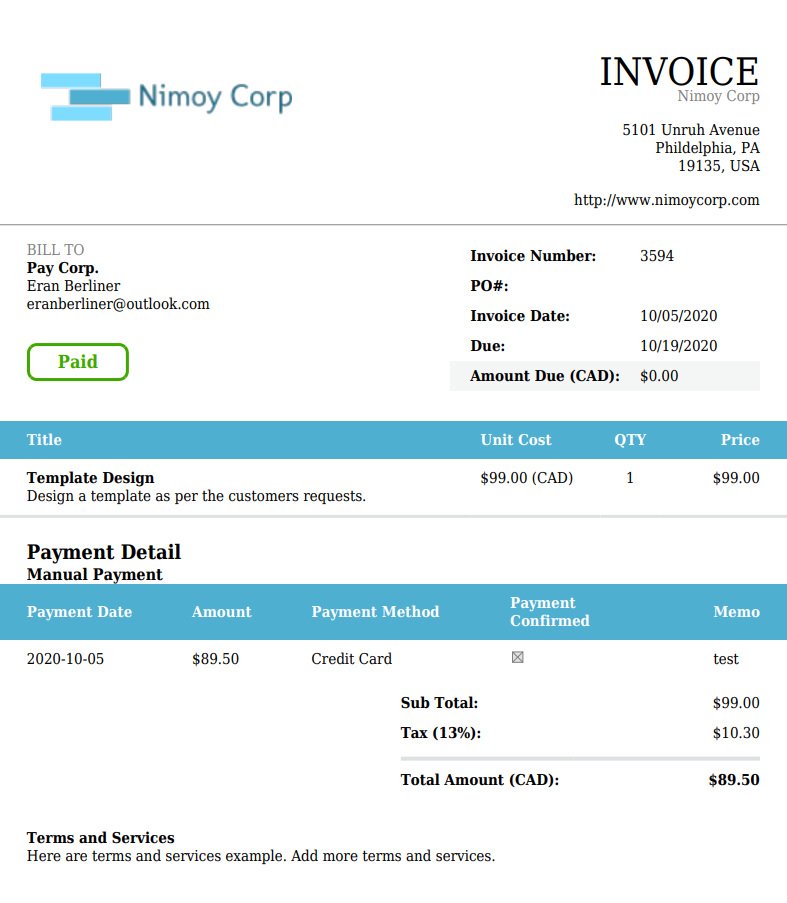

In [60]:
# 어떤 Invoice를 읽어 들인다.


from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import random

invoices=['OCR/invoice/invoice-template-en-band-blue-750px.png',
'OCR/invoice/invoice-template-en-band-blue-760px.png',
'OCR/invoice/invoice-template-en-classic-blue-750px.png',
'OCR/invoice/invoice-paid-1.png']

invoice_file_name = random.choices(invoices)[0]
print(invoice_file_name)
im_data = cv2.imread(invoice_file_name,1)
cv2_imshow(im_data)


In [61]:
# Invoice의 type을 구분할 수 있는 정보가 들어 있는 json 파일을 loading하다.

import json
with open('OCR/type.json') as f:
  types = json.load(f)
types

{'type1': {'Invoice': [48, 380, 182, 424]},
 'type2': {'INVOICE': [593, 74, 688, 102], 'Invoice': [532, 256, 582, 275]},
 'type3': {'Nimoy': [136, 72, 227, 119]}}

In [66]:
# tesseract 를 사용할지 easyocr를 사용할지???

def get_text(img,detail=0):
    results = []
    try:
        if detail == 1:
            data = pytesseract.image_to_data(img)


            for d in data.split('\n')[1:]:
                r = d.split('\t')
                if len(r)==12:
                    x = int(r[6])
                    y = int(r[7])
                    w = int(r[8])
                    h = int(r[9])
                    
                    conf = float(r[10])/100
                    text = r[11]
                    if conf > 0:
                        results.append([[[x,y],[x+w,y],[x,y+h],[x+w,y+h]],text,conf])
            return results
        elif detail == 0:
            results.append(pytesseract.image_to_string(img).strip())
    except:
        pass

    return results

In [67]:
# Invoice의 type을 구분한다.


def type_recognition(im_data,types):
    invoice_type = None

    for k in types:
        # Create a Rectangle patch
        features = types[k]
        isT = True
        for f in features:
            r = features[f]
            text_part=im_data[r[1]:r[3],r[0]:r[2],:]
            result = get_text(text_part,detail=0)
            print(k,[f],result)
            if [f] == result:
                pass
            else:
                isT = False
        if isT:
            invoice_type = k
    return invoice_type

invoice_type = type_recognition(im_data,types)
print('invoice_type:',invoice_type) 

type1 ['Invoice'] ['']
type2 ['INVOICE'] ['Vu\nN']
type2 ['Invoice'] ['']
type3 ['Nimoy'] ['Nimoy']
invoice_type: type3


In [64]:
# Invoice의 각 패턴별, label (항목)의 위치를 정의한 json 파일을 읽는다.

import json
with open('OCR/pattern.json') as f:
  pattern = json.load(f)
pattern_type1 = pattern[invoice_type]
pattern_type1

{'P.O.#': [632, 306, 755, 279],
 'address': [554, 113, 777, 216],
 'bill to': [17, 260, 226, 321],
 'company': [132, 77, 303, 125],
 'due date': [609, 334, 736, 357],
 'invoice date': [611, 302, 726, 327],
 'invoice#': [612, 244, 748, 270],
 'remark': [14, 821, 521, 874],
 'table1': {'rect': [10, 420, 780, 515], 'x': [453, 595, 681]},
 'table2': {'rect': [5, 585, 781, 678], 'x': [160, 281, 473, 644]},
 'total': [383, 683, 775, 793]}

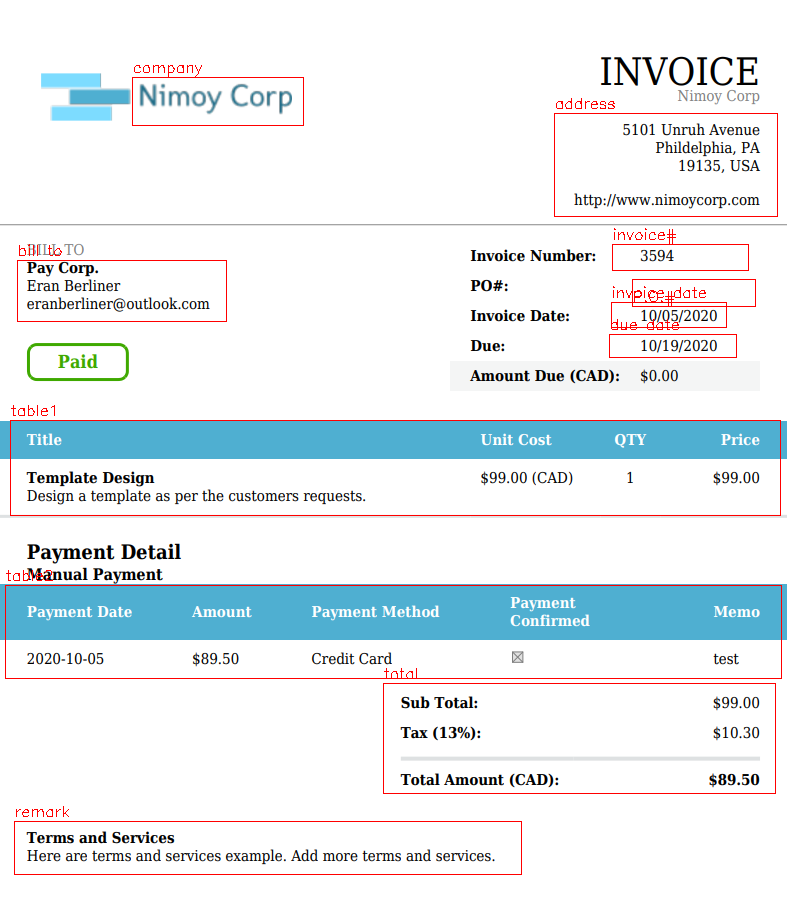

In [68]:
# 각 항목의 위치를 확인

im_data2 = im_data.copy()
# Blue color in BGR 
color = (0, 0, 255) 
# Line thickness of 2 px 
thickness = 1
for k in pattern_type1:
    # Create a Rectangle patch
    r = pattern_type1[k]
    if k.startswith('table'):
        r = r['rect']
    # Using cv2.rectangle() method 
    # Draw a rectangle with blue line borders of thickness of 2 px 
    im_data2 = cv2.rectangle(im_data2, (r[0],r[1]), (r[2],r[3]), color, thickness) 
    im_data2 = cv2.putText(im_data2,k,(r[0],r[1]-5),cv2.FONT_HERSHEY_SIMPLEX,0.5,color)

cv2_imshow(im_data2)


In [69]:
# 각 항목의 OCR 인식


for k in pattern_type1:
    # Create a Rectangle patch
    r = pattern_type1[k]
    if k.startswith('table'):
        r = r['rect']

    text_part=im_data[r[1]:r[3],r[0]:r[2],:]
    try:
        results = get_text(text_part,detail=1)
    except:
        pass
    texts = ""
    for result in results:
        rect = result[0]
        text = result[1]
        prob = result[2]
        texts += ' ' + text + '('+str(prob)+')'

    print(k,':',texts.strip())

company : Nimoy(0.96) Corp(0.96)
address : 5101(0.96) Unruh(0.96) Avenue(0.96) Phildelphia,(0.89) PA(0.9) 19135,(0.95) USA(0.96) http://www.nimoycorp.com(0.79)
bill to : eranberliner@outlook.com(0.86)
invoice# : 3594(0.92)
invoice date : 10/05/2020(0.94)
P.O.# : 
due date : 10/19/2020(0.94)
table1 : Template(0.95) Design(0.96) $99.00(0.89) (CAD)(0.95) 1(0.96) $99.00(0.8) Design(0.96) a(0.96) template(0.95) as(0.96) per(0.96) the(0.96) customers(0.96) requests.(0.96)
table2 : Confirmed(0.92) oe(0.13) SNL(0.16) FCO(0.12) Paton(0.04) 2020-10-05(0.91) $89.50(0.78) Credit(0.89) Card(0.88) test(0.93)
total : Sub(0.95) Total:(0.96) $99.00(0.86) Tax(0.96) (13%):(0.96) $10.30(0.92) Total(0.94) Amount(0.96) (CAD):(0.96) $89.50(0.9)
remark : Terms(0.96) and(0.96) Services(0.96) Here(0.96) are(0.96) terms(0.91) and(0.91) services(0.96) example.(0.92) Add(0.96) more(0.96) terms(0.96) and(0.94) services.(0.94)


In [70]:
# 표 인식

import pandas as pd

class TableImage2DataFrame:
    # Blue color in BGR 
    color = (0, 0, 255) 
    # Line thickness of 2 px 
    thickness = 1    
    def __init__(self, image,table_info):
        self.column_rect = []
        t = table_info['rect']
        self.top = t[1]
        self.column_offset = table_info['x']
        self.end_word = ""
        if 'end' in table_info:
            self.end_word = table_info['end']
        self.raw_offset = []
        self.table_part=image[t[1]:t[3],t[0]:t[2],:]
        self.lx = t[2]-t[0]-1
        self.ly = t[3]-t[1]-1
        table_part2 = self.table_part.copy()
        xs = [0] + [x-t[0] for x in self.column_offset]+[self.lx]
        for i in range(len(xs)-1):
            rect = [(xs[i],0),(xs[i+1],self.ly)]
            self.column_rect.append(rect)

        for tr in self.column_rect:
            table_part2 = cv2.rectangle(table_part2, tr[0],tr[1], color, thickness)

        #cv2_imshow(table_part2) 

    def __add_offset(self,yos,offset_range=15):
        
        allow_add = True
        for ro in self.raw_offset:
            if yos > ro-offset_range and yos < ro+offset_range:
                allow_add = False
        if allow_add:
            self.raw_offset.append(yos)

    def __get_rawoffset(self):
        for (r0,r1),(r2,r3) in self.column_rect:     
            text_part=self.table_part[r1:r3,r0:r2,:]
            results = get_text(text_part,detail=1)
            texts = ""
            for result in results:
                rect = result[0]
                #print(rect)
                text = result[1]
                if len(self.end_word) > 0 and text.find(self.end_word) > -1:
                    self.__add_offset(rect[0][1]-10)
                    self.__add_offset(rect[2][1]+10)
                    #print(text)
                    return None
                else:
                    self.__add_offset(rect[0][1]-10)
        self.__add_offset(self.ly)
        #print(self.raw_offset)

    def get_table_data(self,scale_percent = 200,rate_threshold=0.4):
        self.__get_rawoffset()
        self.raw_offset.sort()
        #print(self.raw_offset)
        data = {}
        for (r0,r1),(r2,r3) in self.column_rect:
            header = ""   
            for i in range(len(self.raw_offset)-1):
                text_part=self.table_part[self.raw_offset[i]:self.raw_offset[i+1],r0:r2,:]
                text = ' '.join(get_text(text_part,detail=0))
                if i == 0:
                    header = text.strip()
                    data[header] = []
                else:
                    data[header].append(text.strip())

        df = pd.DataFrame(data) 
        return df, max(self.raw_offset) + self.top

In [71]:
anchor_offset = {}
for k in pattern_type1:
    r = pattern_type1[k]
    #가변 Y의 경우... 
    if len(r) == 5:
        last_y = anchor_offset[r[4]]
        r[3] = (r[3] - r[1]) + last_y
        r[1] = last_y    
    if k.startswith('table'):
        td = TableImage2DataFrame(im_data,r)
        df,ly = td.get_table_data(scale_percent=100)
        print(df)
        anchor_offset[k] = ly   
    else:
        text_part=im_data[r[1]:r[3],r[0]:r[2],:]
        text = ' '.join(get_text(text_part,detail=0))   
        print(k,':',text.strip())
        anchor_offset[k] = r[3]

company : Nimoy Corp
address : 5101 Unruh Avenue
Phildelphia, PA
19135, USA

http://www.nimoycorp.com
bill to : eranberliner@outlook.com
invoice# : 3594
invoice date : 10/05/2020
P.O.# : 
due date : 10/19/2020
         
0  eoo nn
1        
        PON y     ENC    Paton Cad Be\nConfirmed  Memo
0  2020-10-05  $89.50  Credit Card                test
total : Sub Total: $99.00
Tax (13%): $10.30

Total Amount (CAD): $89.50
remark : Terms and Services
Here are terms and services example. Add more terms and services.


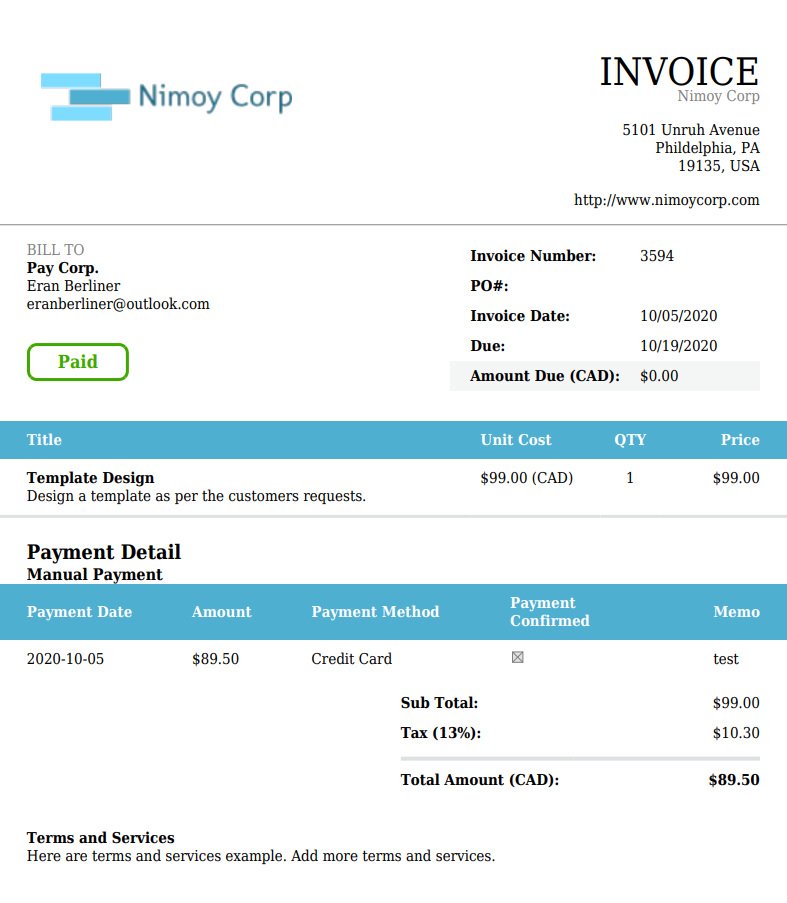

type1 ['Invoice'] ['']
type2 ['INVOICE'] ['Vu\nN']
type2 ['Invoice'] ['']
type3 ['Nimoy'] ['Nimoy']
company : Nimoy Corp
address : 5101 Unruh Avenue
Phildelphia, PA
19135, USA

http://www.nimoycorp.com
bill to : eranberliner@outlook.com
invoice# : 3594
invoice date : 10/05/2020


ValueError: ignored

In [53]:
invoice_file_name = random.choices(invoices)[0]
#print(invoice_file_name)
im_data = cv2.imread(invoice_file_name,1)
cv2_imshow(im_data)

invoice_type = type_recognition(im_data,types)
pattern_type1 = pattern[invoice_type]

anchor_offset = {}
for k in pattern_type1:
    r = pattern_type1[k]
    #가변 Y의 경우... 
    if len(r) == 5:
        last_y = anchor_offset[r[4]]
        r[3] = (r[3] - r[1]) + last_y
        r[1] = last_y    
    if k.startswith('table'):
        td = TableImage2DataFrame(im_data,r)
        df,ly = td.get_table_data(scale_percent=100)
        print(df)
        anchor_offset[k] = ly   
    else:
        text_part=im_data[r[1]:r[3],r[0]:r[2],:]
        text = ' '.join(get_text(text_part,detail=0))   
        print(k,':',text.strip())
        anchor_offset[k] = r[3]
